---
---
# Previsão de Customer Churn em Operadoras de Telecom 
---
---

## Pré-processamento dos Dados // _Pre-processing_

In [1]:
# Versão da Linguagem Python // Python language version
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Instala o pacote
#!pip install -q imblearn

In [3]:
# Imports
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import imblearn
from imblearn.over_sampling import SMOTENC
#import warnings
#warnings.filterwarnings("ignore")

In [4]:
# Versões dos pacotes usados neste jupyter notebook // Versions of packages used in this jupyter notebook
#!pip install -q -U watermark
%reload_ext watermark
%watermark -a "Tatiana Novaes Carvalho" --iversions

Author: Tatiana Novaes Carvalho

numpy     : 1.22.3
joblib    : 1.1.0
sklearn   : 1.1.2
matplotlib: 3.5.1
seaborn   : 0.11.2
pandas    : 1.4.2
imblearn  : 0.0



### DATASET DE TREINO | _TRAINING DATA SET_

### Carga dos dados // Data load

In [5]:
# Carrega os dados // Load the data
df = pd.read_csv('../datasets/df_eng.csv',  index_col = 0)

In [6]:
df.shape

(3169, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 1 to 3333
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   state                  3169 non-null   object
 1   account_length         3169 non-null   object
 2   area_code              3169 non-null   int64 
 3   international_plan     3169 non-null   object
 4   voice_mail_plan        3169 non-null   object
 5   number_vmail_messages  3169 non-null   object
 6   total_day_minutes      3169 non-null   int64 
 7   total_day_calls        3169 non-null   int64 
 8   total_eve_minutes      3169 non-null   int64 
 9   total_eve_calls        3169 non-null   int64 
 10  total_night_minutes    3169 non-null   int64 
 11  total_night_calls      3169 non-null   int64 
 12  total_intl_minutes     3169 non-null   int64 
 13  total_intl_calls       3169 non-null   int64 
 14  churn                  3169 non-null   object
dtypes: int64(9), object(6

In [8]:
df.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
1,KS,Igual ou superior à média,415,no,yes,Igual ou superior à média,4,3,3,3,4,3,3,1,no
2,OH,Igual ou superior à média,415,no,yes,Igual ou superior à média,3,4,3,3,4,3,4,1,no
3,NJ,Igual ou superior à média,415,no,no,Inferior à média,4,4,2,3,2,3,4,2,no
4,OH,Inferior à média,408,yes,no,Inferior à média,5,2,1,2,3,3,2,3,no
5,OK,Inferior à média,415,yes,no,Inferior à média,3,4,2,4,3,4,3,1,no


### Separação das Variáveis Binárias e não Binárias // _Separation of Binary and Non-Binary Variables_

In [9]:
# Lista de colunas categóricas // List of categorical columns
cat_features = ['state',
                'area_code', 
                'international_plan', 
                'voice_mail_plan',
               ]

binary_features = ['account_length',
                   'international_plan', 
                   'voice_mail_plan',
                   'number_vmail_messages',
                  ]

onehot_features = ['state', 'area_code']
cols_tot =  [col for col in df.columns if col.startswith('total')]
onehot_features.extend(cols_tot)


# Variável-alvo // Target
target = ['churn']

In [10]:
# Conversáo do tipo das variáveis para categórica para possibilitar o balanceamento com SMOTE

for feat in cat_features:
    df[feat] = df[feat].astype('category')

### Pré-processamento dos dados // _Data pre-processing_

Os datasets de treino e de teste foram carregados separadamente, de forma que a etapa de divisão do dataset em treino e teste está superada.

---
_The training and test datasets were loaded separately, so the step of dividing the dataset into train and test is over._

> Formatação da target e demais variáveis binárias

In [11]:
# Formatação da target (para substituição das classes 'yes' e 'no' por 1 e 0)
df['churn'] = df['churn'].apply(lambda x: 1 if x == 'yes' else 0)

# Formatação das demais variáveis binárias
df['international_plan'] = df['international_plan'].apply(lambda x: 1 if x == 'yes' else 0)
df['voice_mail_plan'] = df['voice_mail_plan'].apply(lambda x: 1 if x == 'yes' else 0)

# Formatação das demais variáveis binárias
df['account_length'] = np.where(df['account_length'] =='Igual ou superior à média', 1, 0)
df['number_vmail_messages'] = np.where(df['number_vmail_messages'] =='Igual ou superior à média', 1, 0)

> Balanceamento de dados // _Data balancing_

Classes desbalanceadas:
Churn no: 2727 - 86.0%
Churn yes: 442 - 14.0%


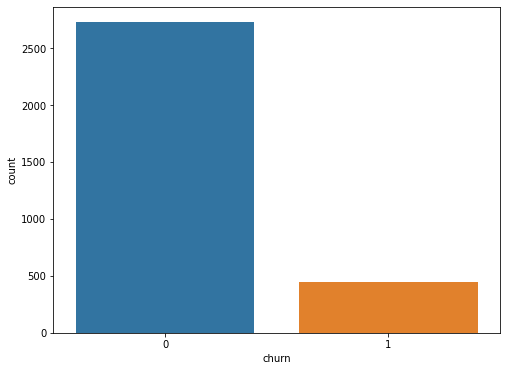

In [12]:
# Variável target // Target Variable #https://sigmoidal.ai/como-lidar-com-dados-desbalanceados/
# apenas nos dados de treino

# Plot
plt.figure(figsize = (8, 6))
sns.countplot(data = df, x = 'churn', label = 'Count')

# Value counts
df['churn'].value_counts()           
no, yes = df['churn'].value_counts() 

# Percentuais
no_perc, yes_perc = round(df['churn'].value_counts()/len(df) * 100) 

# Print
print('Classes desbalanceadas:')
print(f'Churn no: {no} - {no_perc}%')
print(f'Churn yes: {yes} - {yes_perc}%')

**Observação:** Se forem oferecidos muito mais exemplos de uma das classes ao algoritmo de machine learning, o modelo aprenderá muito mais sobre uma classe do que sobre a outra, o que geraria viés no aprendizado. Assim, torna-se necessário fazer o balanceamento da variável target, por meio da criação de dados sintéticos com o mesmo padrão para a classe minoritária. Como essa transformação é realizada para que não ocorra erro no aprendizado, e considerando que os dados de teste visam avaliar o modelo treinado, o balanceamento deve ser aplicado somente aos dados de treino.

---

**_Observation:_** _If the machine learning algorithm is given many more examples of one of the classes, the model will learn much more about one class than the other, which would lead to learning bias. Thus, it becomes necessary to balance the target variable, by creating synthetic data with the same pattern for the minority class. As this transformation is performed so that there is no error in learning, and considering that the test data aim to evaluate the trained model, the balancing must be applied only to the training data._

In [13]:
# Apuração dos índices das variáveis categóricas para uso como argumento na função SMOTENC
# Calculation of the indices of the categorical variables to be used as an argument in the SMOTENC function

print(cat_features)
for i, f in enumerate(df.columns):
    print(i,f)

['state', 'area_code', 'international_plan', 'voice_mail_plan']
0 state
1 account_length
2 area_code
3 international_plan
4 voice_mail_plan
5 number_vmail_messages
6 total_day_minutes
7 total_day_calls
8 total_eve_minutes
9 total_eve_calls
10 total_night_minutes
11 total_night_calls
12 total_intl_minutes
13 total_intl_calls
14 churn


In [14]:
# Aplicação da técnica de oversampling para aumentar o número de exemplos da classe minoritária
# Application of the oversampling technique to increase the number of minority class examples

# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC
    
over_sampler = SMOTENC(categorical_features= [0, 2, 3, 4], k_neighbors = 2)

X_train = df.drop(target, axis = 1)
y_train = df[target]

# Aplica o oversampling (deve ser feito somente com dados de treino)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)

print(len(X_res))
print(len(y_res))
print(y_res.value_counts())

# Ajusta o nome do dataset de treino para X
X_train = X_res

# Ajusta o nome do dataset de treino para y
y_train = y_res

display(X_train.head())
display(y_train.head())


5454
5454
churn
0        2727
1        2727
dtype: int64


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls
0,KS,1,415,0,1,1,4,3,3,3,4,3,3,1
1,OH,1,415,0,1,1,3,4,3,3,4,3,4,1
2,NJ,1,415,0,0,0,4,4,2,3,2,3,4,2
3,OH,0,408,1,0,0,5,2,1,2,3,3,2,3
4,OK,0,415,1,0,0,3,4,2,4,3,4,3,1


,churn
0,0
1,0
2,0
3,0
4,0


In [15]:
y_train.value_counts()

churn
0        2727
1        2727
dtype: int64

In [16]:
df = X_train.copy()
df[target] = y_train
df.head()


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
0,KS,1,415,0,1,1,4,3,3,3,4,3,3,1,0
1,OH,1,415,0,1,1,3,4,3,3,4,3,4,1,0
2,NJ,1,415,0,0,0,4,4,2,3,2,3,4,2,0
3,OH,0,408,1,0,0,5,2,1,2,3,3,2,3,0
4,OK,0,415,1,0,0,3,4,2,4,3,4,3,1,0


In [17]:
df['churn'].value_counts()

0    2727
1    2727
Name: churn, dtype: int64

> One Hot Encoding

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   state                  5454 non-null   category
 1   account_length         5454 non-null   int32   
 2   area_code              5454 non-null   category
 3   international_plan     5454 non-null   category
 4   voice_mail_plan        5454 non-null   category
 5   number_vmail_messages  5454 non-null   int32   
 6   total_day_minutes      5454 non-null   int64   
 7   total_day_calls        5454 non-null   int64   
 8   total_eve_minutes      5454 non-null   int64   
 9   total_eve_calls        5454 non-null   int64   
 10  total_night_minutes    5454 non-null   int64   
 11  total_night_calls      5454 non-null   int64   
 12  total_intl_minutes     5454 non-null   int64   
 13  total_intl_calls       5454 non-null   int64   
 14  churn                  5454 non-null   i

In [19]:
# One Hot Encoding para as variáveis categóricas nominais // One Hot Encoding for nominal categorical variables

# Aplicação de one hot encoding em variáveis categóricas nominais binárias
for col in onehot_features:

    # Aplicação do objeto encoder treinado (datasets de treino, de teste e novos dados)
    # (deve ser feito em dados de treino e teste e também em novos dados usados no modelo)
    onehots = pd.get_dummies(df[col], prefix = col)
    df = df.join(onehots)
    
# Remoção das colunas originais
df = df.drop(columns = onehot_features)
    
# Resultado
display(df.head())


,account_length,international_plan,voice_mail_plan,number_vmail_messages,churn,state_AK,state_AL,state_AR,state_AZ,state_CA,...,total_intl_minutes_1,total_intl_minutes_2,total_intl_minutes_3,total_intl_minutes_4,total_intl_minutes_5,total_intl_calls_1,total_intl_calls_2,total_intl_calls_3,total_intl_calls_4,total_intl_calls_5
0,1,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [20]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 99 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   account_length         5454 non-null   int32   
 1   international_plan     5454 non-null   category
 2   voice_mail_plan        5454 non-null   category
 3   number_vmail_messages  5454 non-null   int32   
 4   churn                  5454 non-null   int64   
 5   state_AK               5454 non-null   uint8   
 6   state_AL               5454 non-null   uint8   
 7   state_AR               5454 non-null   uint8   
 8   state_AZ               5454 non-null   uint8   
 9   state_CA               5454 non-null   uint8   
 10  state_CO               5454 non-null   uint8   
 11  state_CT               5454 non-null   uint8   
 12  state_DC               5454 non-null   uint8   
 13  state_DE               5454 non-null   uint8   
 14  state_FL               5454 non-null   u

None

In [21]:
# Gravação do df em disco // Write df to disk
df.to_csv('../datasets/df_train_balanced.csv', sep = ',', encoding = 'utf-8')
#df_train_stats.to_csv('../datasets/df_train_stats.csv', sep = ',', encoding = 'utf-8')

### DATASET DE TESTE | _TEST DATA SET_


In [22]:
# Carrega os dados // Load the data
df_test = pd.read_csv('../datasets/df_test_eng.csv', index_col = 0)

print(df_test.shape)
display(df_test.head())

(1667, 15)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
1,HI,Igual ou superior à média,510,no,no,Inferior à média,1,4,3,2,4,2,2,1,no
2,MT,Igual ou superior à média,510,no,no,Inferior à média,4,2,4,5,1,2,2,3,no
3,OH,Igual ou superior à média,408,no,yes,Igual ou superior à média,5,3,4,3,5,4,4,3,no
4,NM,Inferior à média,415,no,no,Inferior à média,4,4,2,2,3,2,2,1,no
5,SC,Igual ou superior à média,415,no,no,Inferior à média,3,2,2,3,3,3,3,2,no


In [23]:
df_test.isnull().sum()

state                    0
account_length           0
area_code                0
international_plan       0
voice_mail_plan          0
number_vmail_messages    0
total_day_minutes        0
total_day_calls          0
total_eve_minutes        0
total_eve_calls          0
total_night_minutes      0
total_night_calls        0
total_intl_minutes       0
total_intl_calls         0
churn                    0
dtype: int64

In [24]:
# Conversão do tipo de dado das variáveis iniciadas com total para int

cols_discret =  [col for col in df_test.columns if col.startswith('total')]
for col in cols_discret:
    df_test[col] =  df_test[col].astype(int)

display(df_test.head())

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
1,HI,Igual ou superior à média,510,no,no,Inferior à média,1,4,3,2,4,2,2,1,no
2,MT,Igual ou superior à média,510,no,no,Inferior à média,4,2,4,5,1,2,2,3,no
3,OH,Igual ou superior à média,408,no,yes,Igual ou superior à média,5,3,4,3,5,4,4,3,no
4,NM,Inferior à média,415,no,no,Inferior à média,4,4,2,2,3,2,2,1,no
5,SC,Igual ou superior à média,415,no,no,Inferior à média,3,2,2,3,3,3,3,2,no


In [25]:
# Aplicação das mesmas transformações efetuadas no dataset de treino no dataset de teste
# Application of the same transformations performed on the train dataset in the test dataset

# Formatação da target (para substituição das classes 'yes' e 'no' por 1 e 0)
df_test['churn'] = df_test['churn'].apply(lambda x: 1 if x == 'yes' else 0)

# Formatação das demais variáveis binárias
df_test['international_plan'] = df_test['international_plan'].apply(lambda x: 1 if x == 'yes' else 0)
df_test['voice_mail_plan'] = df_test['voice_mail_plan'].apply(lambda x: 1 if x == 'yes' else 0)

df_test['account_length'] = np.where(df_test['account_length'] =='Igual ou superior à média', 1, 0)
df_test['number_vmail_messages'] = np.where(df_test['number_vmail_messages'] =='Igual ou superior à média', 1, 0)

# Aplicação de one hot encoding em variáveis categóricas

for col in onehot_features:

    # Aplicação do objeto encoder treinado (datasets de treino, de teste e novos dados)
    # (fazemos isso em dados de treino e teste e também em novos dados usados no modelo)
    onehots = pd.get_dummies(df_test[col], prefix = col)
    df_test = df_test.join(onehots)
    
# Remoção das colunas originais
df_test = df_test.drop(columns = onehot_features)
    
# Resultado
display(df_test.head())

,account_length,international_plan,voice_mail_plan,number_vmail_messages,churn,state_AK,state_AL,state_AR,state_AZ,state_CA,...,total_intl_minutes_1,total_intl_minutes_2,total_intl_minutes_3,total_intl_minutes_4,total_intl_minutes_5,total_intl_calls_1,total_intl_calls_2,total_intl_calls_3,total_intl_calls_4,total_intl_calls_5
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1667 entries, 1 to 1667
Data columns (total 99 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   account_length         1667 non-null   int32
 1   international_plan     1667 non-null   int64
 2   voice_mail_plan        1667 non-null   int64
 3   number_vmail_messages  1667 non-null   int32
 4   churn                  1667 non-null   int64
 5   state_AK               1667 non-null   uint8
 6   state_AL               1667 non-null   uint8
 7   state_AR               1667 non-null   uint8
 8   state_AZ               1667 non-null   uint8
 9   state_CA               1667 non-null   uint8
 10  state_CO               1667 non-null   uint8
 11  state_CT               1667 non-null   uint8
 12  state_DC               1667 non-null   uint8
 13  state_DE               1667 non-null   uint8
 14  state_FL               1667 non-null   uint8
 15  state_GA               1667 non-null  

In [27]:
# Gravação dos dados transformados em disco // Writing the transformed data to disk
df_test.to_csv('../datasets/df_test_proc.csv')